# Sparse Score Fusion for Classifying Mate Pairs of Images

##  Challenge MDI343 2017-2018

## Introduction

#### Authors:  Umut Şimşekli & Stéphane Gentric

The topic of this challenge will be determining if two images belong to the same person or not. Conventionally, in order to solve this task, one typically builds an algorithm to provide a "score" for a given image pair. If the value of the score is high, it means that it is more probable that these images belong to the same person. Then, by using this score, one can determine if the images belong to the same person, by simply thresholding it.   

The goal of this challenge is to build a system for determining if two images belong to the same person or not by "fusing" multiple algorithms. In particular, for a given image pair, you will be provided the scores obtained from **14** different algorithms, each of which has a different computational complexity.   

Then the aim is to combine the scores of these algorithms (in a way that will be described in the sequel) in order to obtain a better classification accuracy. However, there will be a strict **computational budget**, such the running times of the algorithms that you combine **cannot exceed a certain time threshold**. For example, let $t_i$ denote the running time of algorithm $i$ in milliseconds ($i = 1,\dots,14$). Then, you will be given a threshold, $T$, such that the total computational time of the algorithms that you combine will not exceed $T$: 

$
\sum_{i\in C} t_i \leq T,
$

where $C \subset \{1,\dots,14\}$ is the set of algorithms that you choose to combine. The idea in such fusion is that "combining several fast algorithms might be better than using a single slow (possible more complex) algorithm". 

Before we describe how the fusion will be done, let us introduce the data:

**Training data:**

There will be $N= 2048853$ image pairs in the dataset. For a given image pair $n \in \{1,\dots,N\}$, we define $y_n = 1$ if this image pair belongs to the same person, or $y_n=0$ otherwise.

We then define a vector of scores for each image pair, $s_n \in \mathbb{R}_+^{14}$, such that $i$th component of $s_n$ will encode the score obtained by the $i$th algorithm, for the given image pair.  

**Test data:**

The test data contain $N_\text{test} = 170738$ image pairs. Similarly to the training data, each image pair contains a label and a vector of scores that are obtained from $14$ different algorithms. The test data will not be provided.


### Fusion Method 

In this challenge, you are expected to build a fusion system that is given as follows. Given a score vector $s \in \mathbb{R}_+^{14}$, we first define an extended vector $s'$, by appending a $1$ in the beginning of the original vector $s\in \mathbb{R}_+^{15}$: $s' = [1, s]$. Then we use the following fusion scheme in order to obtain the combined score $\hat{s}$: 

$
\hat{s} = s'^\top M s' 
$

where $M \in \mathbb{R}^{15 \times 15}$, is the "fusion matrix". This matrix will enable you to combine the scores of the different algorithms in a linear or a quadratic way. 


### The goal and the performance criterion

In this challenge, we will use an evaluation metric, which is commonly used in biometrics, namely the False Recognition Rate (FRR) at a fixed False Acceptance Rate (FAR). **The lower the better.**

The definitions of these quantities are as follows: (definitions from Webopedia)

**The false acceptance rate**, or **FAR**, is the measure of the likelihood that the biometric security system will incorrectly accept an access attempt by an unauthorized user. A system’s FAR typically is stated as the ratio of the number of false acceptances divided by the number of identification attempts.

**The false recognition rate**, or **FRR**, is the measure of the likelihood that the biometric security system will incorrectly reject an access attempt by an authorized user. A system’s FRR typically is stated as the ratio of the number of false recognitions divided by the number of identification attempts.

In this challenge, we will use the following evaluation scheme:

1) Given the scores, find a threshold that will give an FAR 0.01 %

2) Given the threshold, compute the FRR

The overall metric will be called **"the FRR at 0.01% FAR"**.


### Training Data

https://www.dropbox.com/s/6it6v6ifqkwuz98/train15_telecom.txt?dl=0


## Resolution

#### Author: Clément Probel

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy import special  # special.comb N choose k
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, StratifiedKFold
import itertools
from MDI343_challenge_utils import *

In [5]:
# Load the data
train_fname = 'train15_telecom.txt'

# The first column contains the labels, the rest of the columns contains the scores
train_data = np.loadtxt(train_fname, dtype=np.float)
train_data = train_data[~np.isin(train_data, [np.nan, np.inf, -np.inf]).any(1), :]  # Remove undesired values
# train_data = train_data[~np.any(train_data < 0, axis=1), :]  # Remove negative values

# Extract the labels
y_trn = train_data[:, 0].astype(int)

# Extract the score vectors
s_trn = train_data[:, 1:]

# Put a 1 in front of all the scores (see the "Fusion method" section above)
s_trn_1 = np.hstack([np.ones((s_trn.shape[0], 1)), s_trn])


This challenge is a binary classification problem. Before explaning the strategy, this is interesting to see if we can get *a priori* information about the best algorithms (first, without checking the computation time constraint).

## Exploratory Analysis

In [6]:
df = pd.DataFrame(train_data)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.0,4056.64,4329.06,4258.26,4487.92,4438.95,4624.01,4295.81,4516.67,5566.92,5365.55,3534.17,3877.52,4933.86,4970.20
1,0.0,2284.19,2448.09,2148.12,2246.95,2379.43,2581.86,2530.12,2782.97,2397.09,2606.08,1906.96,1856.95,2743.85,3048.56
2,0.0,2158.96,2263.43,2369.36,2567.98,2385.78,2590.60,2320.31,2499.47,2155.66,2258.41,1938.28,1910.30,2837.74,3158.75
3,0.0,2257.80,2410.03,2297.49,2467.10,2280.85,2443.30,2293.67,2461.65,2200.40,2325.69,1989.81,1996.23,2548.51,2806.69
4,0.0,2094.92,2164.81,1830.91,1723.67,2239.55,2383.45,2038.94,2076.11,2465.04,2697.64,1617.28,1317.34,2802.02,3117.27


In [7]:
df[0].value_counts()

0.0    1997772
1.0      51068
Name: 0, dtype: int64

The classes are very unbalanced.

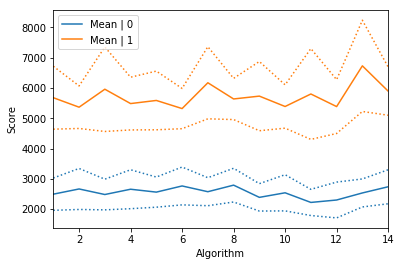

In [176]:
d = df.groupby(0).agg([np.mean, np.std]).stack().T
d[0.0]['mean'].plot(color='#1f77b4', label='Mean | 0')
(d[0.0]['mean'] - d[0.0]['std']).plot(color='#1f77b4', style=':', label='_nolegend_')
(d[0.0]['mean'] + d[0.0]['std']).plot(color='#1f77b4', style=':', label='_nolegend_')
d[1.0]['mean'].plot(color='#ff7f0e', label='Mean | 1')
(d[1.0]['mean'] - d[1.0]['std']).plot(color='#ff7f0e', style=':', label='_nolegend_')
(d[1.0]['mean'] + d[1.0]['std']).plot(color='#ff7f0e', style=':', label='_nolegend_')
plt.xlabel('Algorithm')
plt.ylabel('Score')
plt.legend()
plt.show()

On the plot above, we represent the average score of each algorithm $\pm$ one standard deviation, for each class. *On average*, the scores are very different for the two classes.

In [11]:
(d[1.0]['mean'] - d[0.0]['mean']).sort_values(ascending=False)

13    4194.758201
7     3595.974039
11    3578.942956
3     3475.354429
9     3341.337262
1     3183.542458
14    3157.328560
12    3083.393820
5     3025.532124
10    2848.162246
8     2844.366948
4     2827.034414
2     2698.782728
6     2554.207564
Name: mean, dtype: float64

For a rough idea, the algorithms can be ranked by the difference of their average score on the positives (class 1) and their average score on the negatives (class 0). But let's look at the density of the scores for each algorithm.

Text(0.5,0,'Score')

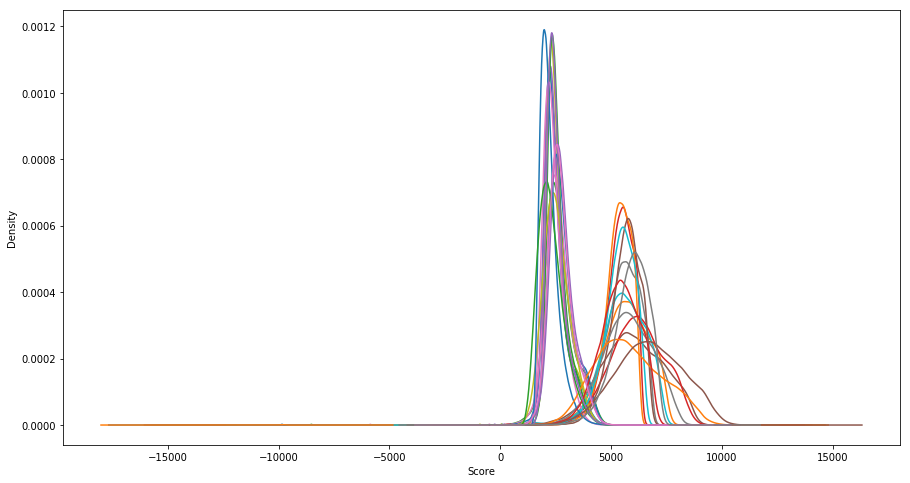

In [90]:
grp = df.groupby(0)
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
for i in range(1, 15):
    grp[i].plot.kde(ax=ax)
ax.set_xlabel('Score')

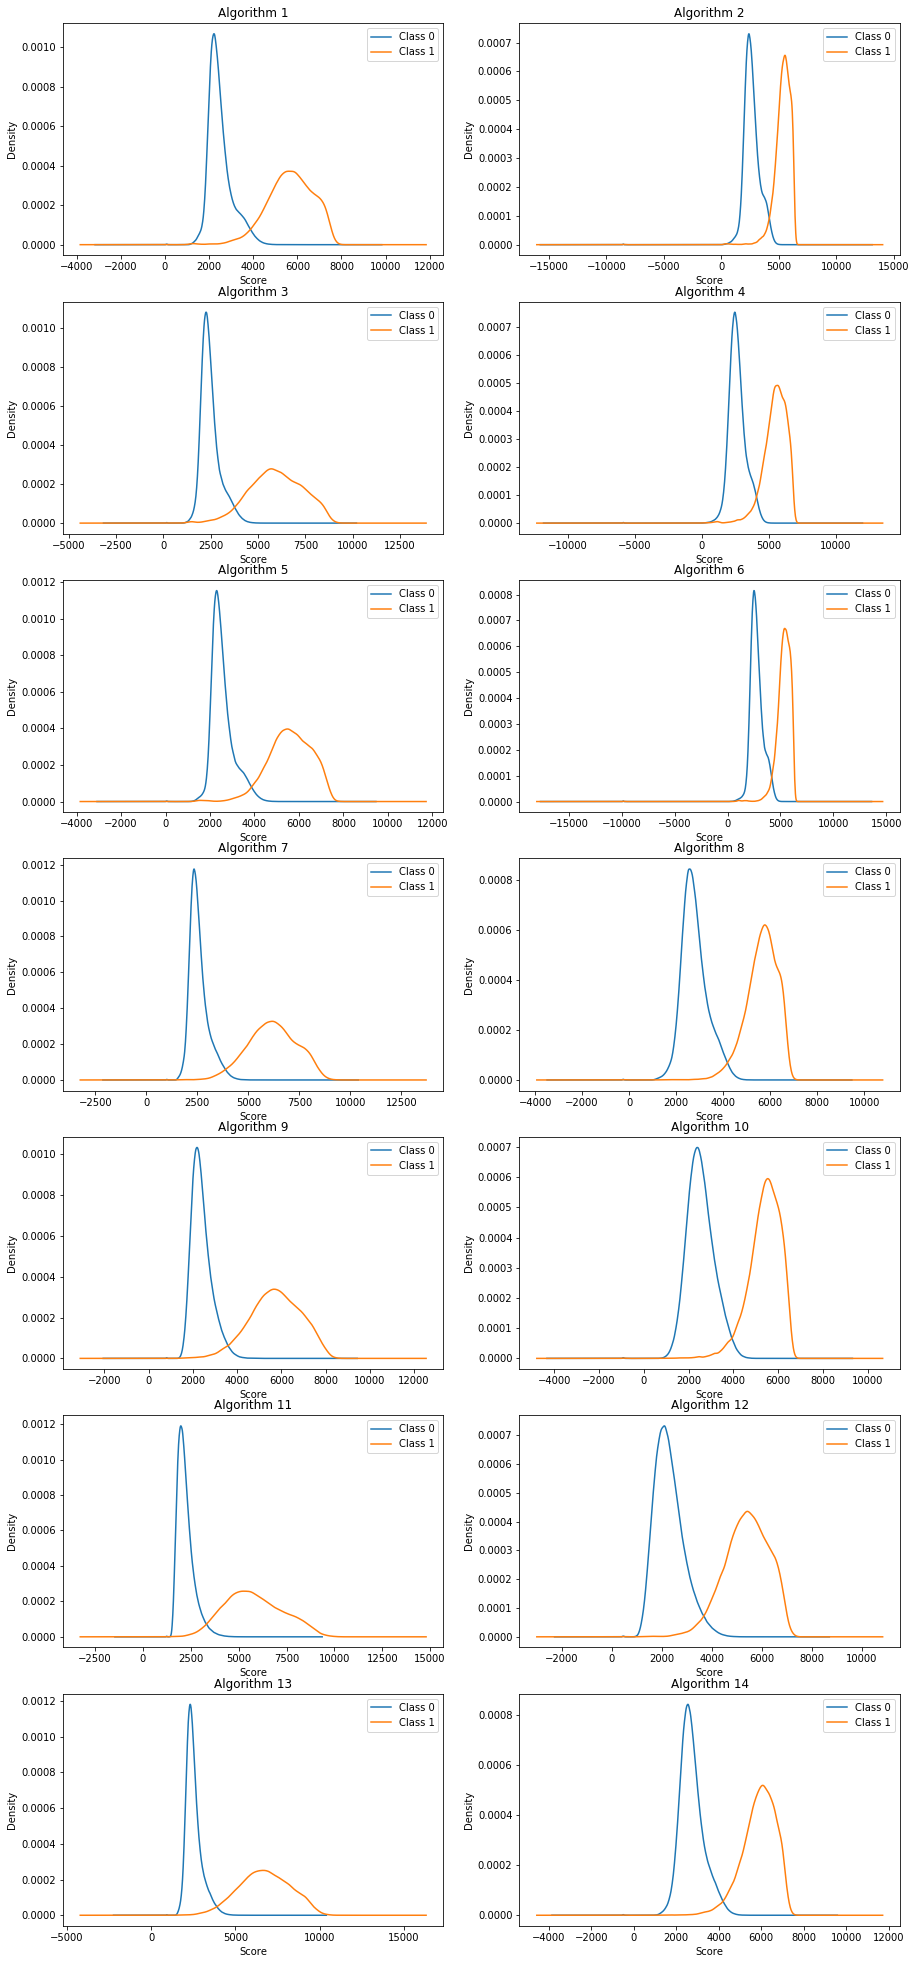

In [93]:
fig, axs = plt.subplots(7, 2, figsize=(15, 35))
grp = df.groupby(0)
for igrp in range(0, 14):
    i, j = igrp // 2, igrp % 2
    grp[igrp + 1].plot.kde(ax=axs[i][j])
    axs[i][j].set_xlabel('Score')    
    axs[i][j].set_title('Algorithm {}'.format(igrp + 1))     
    axs[i][j].legend(['Class 0', 'Class 1'])

We observe that the density functions overlap more or less given the algorithm. If the scores $X_0$ and $X_1$ were normally-distributed random variables, we could calculate the probability of one being bigger than the other ($X_0$ and $X_1$ are independent):

$\mathbb{P}[X_1>X_0]=1-\mathbb{P}[X_1-X_0\leq0]=1-\frac{1}{2}\left[1+\textrm{erf}\left(\frac{0-\mu}{\sigma\sqrt{2}}\right)\right]=\frac{1}{2}\left[1-\textrm{erf}\left(\frac{-(\mu_1-\mu_0)}{\sqrt{2(\sigma_0^2+\sigma_1^2)}}\right)\right]=\frac{1}{2}\textrm{erfc}\left(\frac{-(\mu_1-\mu_0)}{\sqrt{2(\sigma_0^2+\sigma_1^2)}}\right)$,

where $\textrm{erf}$ is the error function, defined as $\textrm{erf}(x)=\frac{2}{\sqrt{\pi}}\int_{0}^{x}e^{-t^2}\textrm{dt}$.

$\mathbb{P}[X_1>X_0]$ can be seen as a measure of separability. Below, the algorithms are ranked by decreasing separability.

In [25]:
(1 / 2 * special.erfc(-(d[1.0]['mean'] - d[0.0]['mean']) /
                      (np.sqrt(2 * (d[0.0]['std']**2 + d[1.0]['std']**2))))).sort_values(ascending=False)

14    0.999401
8     0.999395
10    0.998885
12    0.998082
7     0.997574
6     0.997460
5     0.997274
2     0.997172
1     0.996811
9     0.996730
13    0.996137
4     0.995518
3     0.990438
11    0.989109
dtype: float64

Moreover, we observe from the graph below that consecutive pairs of algorithms (1-2, 3-4, etc.) have highly correlated scores (it is possible that a pair corresponds to the same algorithm used with different parameters).

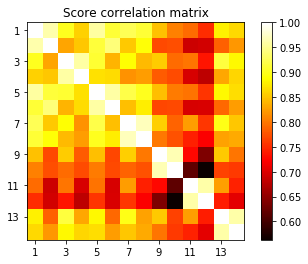

In [50]:
fig, ax = plt.subplots(1, 1)
plt.imshow(np.corrcoef(s_trn, rowvar=False), cmap='hot')
ax.set_xticks(range(0, 14, 2))
ax.set_yticks(range(0, 14, 2))
ax.set_xticklabels(range(1, 15, 2))
ax.set_yticklabels(range(1, 15, 2))
plt.title('Score correlation matrix')
plt.colorbar()
plt.show()

## Problem description

The motivation of this challenge is that a quadratic combination of some scores may give better results (when passed to the score function) than each of these scores. The combination information is contained in a matrix $M\in\mathbb{R}^{15 \times 15}$, called *fusion matrix*, which can be considered upper-triangular for symmetry reasons. If we develop $s'^\top M s'$, we easily see that the coefficients of $M$ at indices:
- $(0,0)$ correspond to a constant,
- $(0,i)$ correspond to linear terms,
- $(i,j), i<j$ correspond to cross-terms,
- $(i,i)$ correspond to quadratic terms,

with $(i,j) \in [1,14]^2$.
 

Only a subset of all possible combinations of algorithms respects the computation time constraint. *compute_total_time*, *check_total_time* were given to check that a particular choice respects the time constraint.

*compute_eval* calculates the FRR at 0.01% FAR by thresholding a score vector *y_score*. *score_func*(*y_true*, *y_score*) is used as a custom scorer for this challenge. The routines can be found in MDI343_challenge_utils.py.

The False Acceptance Rate (FAR) is the probability of accepting a non-authorized person (predict 1 given 0): $FAR = \frac{FP}{TN+FP}=1-\frac{TN}{TN+FP}=1-Specificity$.

The False Recognition Rate (FRR) is the probability of rejecting an authorized person (predict 0 given 1): $FRR = \frac{FN}{TP+FN}=1-\frac{TP}{TP+FN}=1-Recall$.

In [53]:
# Running time of each algorithm (in milliseconds)
alg_times = np.zeros((14,))
alg_times[0] = 163
alg_times[1] = 163
alg_times[2] = 190
alg_times[3] = 190
alg_times[4] = 206
alg_times[5] = 206
alg_times[6] = 120
alg_times[7] = 120
alg_times[8] = 83
alg_times[9] = 83
alg_times[10] = 83
alg_times[11] = 83
alg_times[12] = 170
alg_times[13] = 170

# Time constraint: The total duration of the algorithms cannot exceed 600 milliseconds
alg_time_thr = 600

alg_times.sum()

2030.0

In [54]:
# Check if the time constraint is satisfied:
def check_total_time(M):
    tot_dur = compute_total_time(M, alg_times)
    # print (tot_dur)

    if (tot_dur <= alg_time_thr):
        pass
        # print ("The total running time of the fusion is acceptable!")
    else:
        print ("The total running time of the fusion is NOT acceptable!")


## Preliminary results

A first simple thing we can do is test algorithms individually.

threshold: 5023.26 far: 9.961096661681113e-05 frr: 0.25303516879454846
threshold: 5029.01 far: 9.961096661681113e-05 frr: 0.25303516879454846
threshold: 5028.1 far: 9.961096661681113e-05 frr: 0.2558549385133547
threshold: 5032.16 far: 9.961096661681113e-05 frr: 0.2558549385133547
threshold: 4906.89 far: 9.961096661681113e-05 frr: 0.23106446306884937
threshold: 4952.24 far: 9.961096661681113e-05 frr: 0.23106446306884937
threshold: 5002.08 far: 9.961096661681113e-05 frr: 0.16534816323333595
threshold: 5015.17 far: 9.961096661681113e-05 frr: 0.16534816323333595
threshold: 4659.33 far: 9.961096661681113e-05 frr: 0.17404245319965536
threshold: 4782.7 far: 9.961096661681113e-05 frr: 0.17404245319965536
threshold: 4949.0 far: 9.961096661681113e-05 frr: 0.312994438787499
threshold: 4980.23 far: 9.961096661681113e-05 frr: 0.312994438787499
threshold: 5219.04 far: 9.961096661681113e-05 frr: 0.1629787734001723
threshold: 5154.23 far: 9.961096661681113e-05 frr: 0.1629787734001723


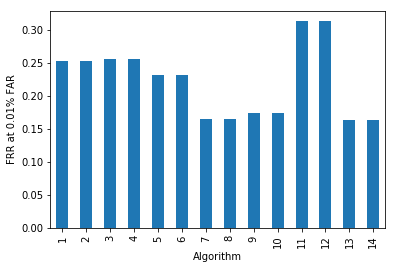

In [55]:
# Test algorithms individually
score_indiv = np.zeros((14,))
for m in range(1, 15):
    M = np.zeros((15, 15))
    M[0, m] = 1.0
    check_total_time(M)
    fuse = np.sum(np.multiply(s_trn_1, np.dot(s_trn_1, M.T)), axis=1)  # efficient
    score_indiv[m - 1] = score_func(y_trn, fuse)

pd.Series(score_indiv, index=range(1, 15)).plot.bar()
plt.xlabel('Algorithm')
plt.ylabel('FRR at 0.01% FAR')
plt.show()

A next simple thing we can do is sum the scores of the combined algorithms, for all combinations possible.

In [94]:
# List combinations of algorithms respecting time constraint
lst = np.array(list(map(list, itertools.product([0, 1], repeat=14))), dtype=bool)
alg_times_combined = np.dot(lst, alg_times)
lst_filtered = lst[(alg_times_combined > 0) & (alg_times_combined < alg_time_thr), :]
lst_filtered.shape

(1199, 14)

In [95]:
np.bincount(np.sum(lst_filtered, axis=1))

array([  0,  14,  91, 362, 593, 138,   1], dtype=int64)

There are around 1200 candidate combinations (14 1-algo, 91 2-algo, ..., 1 6-algo).

In [ ]:
# Summing scores of all candidate combinations (sum and average are equivalent)

score_sum = np.zeros((lst_filtered.shape[0],))

for icombi, combi in enumerate(lst_filtered):
    M = np.zeros((15, 15))
    M[0, 1:][combi] = 1.0
    fuse = np.sum(np.multiply(s_trn_1, np.dot(s_trn_1, M.T)), axis=1)
    print("algorithms: {} ".format(np.where(combi)[0] + 1), end="")
    score_sum[icombi] = score_func(y_trn, fuse)

In [109]:
score_sum.min()

0.08241951907260907

In [120]:
np.where(lst_filtered[score_sum.argmin()])[0] + 1

array([ 8,  9, 10, 11, 14], dtype=int64)

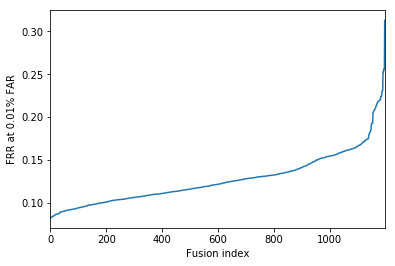

In [111]:
pd.Series(score_sum).sort_values().reset_index(drop=True).plot()
plt.xlabel('Fusion index')
plt.ylabel('FRR at 0.01% FAR')
plt.show()

The best combinations yield around 8% FRR on the whole training set.

## Classification problem

The coefficients of $M$ can be obtained by solving a classification problem, which takes the matrix of scores as input and predicts a label (0 or 1). 
If we fit a linear classifier which separates positives from negatives, the FRR will be zero (which is great).

The coefficients of $M$ can be obtained directly from the coefficients of a linear classifier. Linear classifiers include: logistic regression, perceptron, linear SVM, etc.

To account for quadratic fusion, polynomial and interaction features are added to the input matrix.

The fused score $s'^\top M s'$ is nothing more than a confidence score, i.e. a signed distance to the separating hyperplane. $s'^\top M s'$ is just a 2-D notation of this distance. The coefficients of the hyperplane can be found through linear classification and plugged back into $M$.

*construct_fusion_matrix* is a routine which builds the fusion matrix from the vector of coefficients.

For better score and smaller computation time, the training data is scaled to zero mean and unit variance. As the test data is not scaled, this has to be taken into account while building matrix $M$: new coefficients $c$ must be derived from the coefficients $c'$ obtained from the scaled data $X'$. We look for $c$ such that $\langle c,X\rangle=\langle c',X'\rangle$ where $X$ is the original data:
$\langle c',X'\rangle=c_0'+\sum_{i=1}^{d}c_i'\frac{X_i-\mu_i}{\sigma_i}=\left(c_0'-\sum_{i=1}^{d}c_i'\frac{\mu_i}{\sigma_i}\right)+\sum_{i=1}^{d}\left(\frac{c_i'}{\sigma_i}\right)X_i$, and the $c_i$'s appear. The *scaler* object (which contains the $\mu_i$'s and $\sigma_i$'s) is passed to *construct_fusion_matrix*.



### Examples

First, we fit a logistic regression on the whole training set and check that we obtain the same results from the classifier's decision function and matrix $M$.

In [60]:
scaler = StandardScaler()
clf = LogisticRegression(class_weight='balanced', fit_intercept=False)

s_trn_scaled = scaler.fit_transform(s_trn)
s_trn_scaled_1 = np.hstack([np.ones((s_trn_scaled.shape[0], 1)), s_trn_scaled])

clf.fit(s_trn_scaled_1, y_trn)
score_func(y_trn, clf.decision_function(s_trn_scaled_1))

threshold: 6.216785235432177 far: 9.961096661681113e-05 frr: 0.07638834495182893


0.07638834495182893

In [61]:
# Check
M = construct_fusion_matrix(clf.coef_, scaler=scaler)
fuse = np.sum(np.multiply(s_trn_1, np.dot(s_trn_1, M.T)), axis=1)
score_func(y_trn, fuse)

threshold: 6.216785235432178 far: 9.961096661681113e-05 frr: 0.07638834495182893


0.07638834495182893

This also works when we isolate a subset of columns (algorithms) and add the polynomial features.

In [72]:
col = np.array([8, 9, 10, 11, 14]) - 1  # algorithm combination (0-13)
poly = PolynomialFeatures(degree=2, include_bias=False)

s_trn_poly = poly.fit_transform(s_trn[:, col])
s_trn_poly_scaled = scaler.fit_transform(s_trn_poly)
s_trn_poly_scaled_1 = np.hstack(
    [np.ones((s_trn_poly_scaled.shape[0], 1)), s_trn_poly_scaled])

clf.fit(s_trn_poly_scaled_1, y_trn)
score_func(y_trn, clf.decision_function(s_trn_poly_scaled_1))

threshold: 6.089091584299551 far: 9.961096661681113e-05 frr: 0.08226286519934205


0.08226286519934205

In [75]:
# Check
M = construct_fusion_matrix(clf.coef_, np.insert(
    col + 1, 0, 0), scaler=scaler, poly=True)
fuse = np.sum(np.multiply(s_trn_1, np.dot(s_trn_1, M.T)), axis=1)
score_func(y_trn, fuse)

threshold: 6.089091584299558 far: 9.961096661681113e-05 frr: 0.08226286519934205


0.08226286519934205

The strategy now is to apply a couple of linear classifiers to all (scaled) candidate combinations in order to identify the best combinations. Once we have, say the best 20, we can use them to submit results, modify hyperparameters, test new classifiers, and, more importantly, find the best hyperparameters of a given family of classifiers by cross-validation.

For every candidate combination, we run:
- Logistic regression with L2-penalty on scaled data (*s+LR*)
- Logistic regression with L2-penalty on polynomial, scaled data (*p+s+LR*)
- Perceptron with L1-penalty on polynomial, scaled data (*p+s+PER*)

We use *scikit-learn*. Class imbalance is taken into account via class_weight='balanced'. We fit no intercept as the data already contains a constant column.

As shown above, matrix $M$ is of no help in any calculation. It is only created afterwards, for submission purpose.


### Logistic regression with L2-penalty on scaled data (*s+LR*)

In [ ]:
clf = LogisticRegression(class_weight='balanced', fit_intercept=False, tol=1e-7)

s_trn_scaled = scaler.fit_transform(s_trn)
s_trn_scaled_1 = np.hstack([np.ones((s_trn_scaled.shape[0], 1)), s_trn_scaled])

lst_filtered_1 = np.hstack([np.ones((lst_filtered.shape[0], 1), dtype=bool), lst_filtered])

score_lr = np.zeros((lst_filtered_1.shape[0],))

for icombi, combi in enumerate(lst_filtered_1):
    x_trn = s_trn_scaled_1[:, combi]
    clf.fit(x_trn, y_trn)
    print("algorithms: {} ".format(np.where(combi)[0][1:]), end="")
    score_lr[icombi] = score_func(y_trn, clf.decision_function(x_trn))

In [15]:
score_lr.min()

0.08192997571864964

In [16]:
np.where(lst_filtered[score_lr.argmin()])[0] + 1

(array([ 0,  7,  9, 10, 11, 13], dtype=int64),)

### Logistic regression with L2-penalty on polynomial, scaled data (*p+s+LR*)

In [ ]:
clf = LogisticRegression(class_weight='balanced',
                         fit_intercept=False, tol=1e-7)

score_poly_lr = np.zeros((lst_filtered.shape[0],))

for icombi, combi in enumerate(lst_filtered):
    x_trn = s_trn[:, combi]
    s_trn_poly = poly.fit_transform(x_trn)
    s_trn_poly_scaled = scaler.fit_transform(s_trn_poly)
    s_trn_poly_scaled_1 = np.hstack(
        [np.ones((s_trn_poly_scaled.shape[0], 1)), s_trn_poly_scaled])
    clf.fit(s_trn_poly_scaled_1, y_trn)
    print("algorithms: {} ".format(np.where(combi)[0] + 1), end="")
    score_poly_lr[icombi] = score_func(
        y_trn, clf.decision_function(s_trn_poly_scaled_1))

In [18]:
score_poly_lr.min()

0.08061799953003838

In [19]:
np.where(lst_filtered[score_poly_lr.argmin()])[0] + 1

(array([ 0,  7,  9, 12, 13], dtype=int64),)

### Perceptron with L1-penalty on polynomial, scaled data (*p+s+PER*)

In [ ]:
clf = Perceptron(class_weight='balanced', fit_intercept=False, penalty='l1', tol=1e-10, max_iter=1e5)

score_poly_per = np.zeros((lst_filtered.shape[0],))

for icombi, combi in enumerate(lst_filtered):
    x_trn = s_trn[:, combi]
    s_trn_poly = poly.fit_transform(x_trn)
    s_trn_poly_scaled = scaler.fit_transform(s_trn_poly)
    s_trn_poly_scaled_1 = np.hstack(
        [np.ones((s_trn_poly_scaled.shape[0], 1)), s_trn_poly_scaled])
    clf.fit(s_trn_poly_scaled_1, y_trn)
    print("algorithms: {} ".format(np.where(combi)[0] + 1), end="")
    score_poly_per[icombi] = score_func(y_trn, clf.decision_function(s_trn_poly_scaled_1))

In [21]:
score_poly_per.min()

0.08116628808647294

In [22]:
np.where(lst_filtered[score_poly_per.argmin()])[0] + 1

(array([ 0,  7,  9, 11, 13], dtype=int64),)

### Aggregation

At this stage, we can find the best N (= 20) combinations, i.e. those with the smallest average FRR at 0.01% FAR  (a combination which gives good results in three different contexts can be considered a "good" combination).

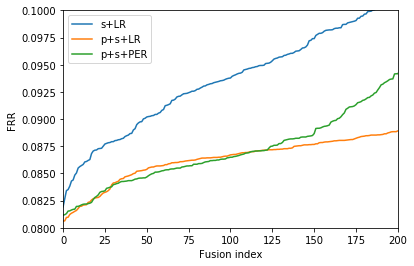

In [32]:
# Plot the best scores obtained by each method
pd.Series(score_lr).sort_values().reset_index(drop=True).plot(label='s+LR')
pd.Series(score_poly_lr).sort_values().reset_index(drop=True).plot(label='p+s+LR')
pd.Series(score_poly_per).sort_values().reset_index(drop=True).plot(label='p+s+PER')
plt.legend()
plt.xlim(0, 200)
plt.ylim(0.08, 0.10)
plt.xlabel('Fusion index')
plt.ylabel('FRR at 0.01% FAR')
plt.show()

In [123]:
# The best combinations for one method
pd.Series(score_poly_per).sort_values().head(10)

150    0.081166
159    0.081205
185    0.081303
192    0.081538
147    0.081558
191    0.081636
569    0.081695
101    0.081715
579    0.081969
102    0.081969
dtype: float64

In [ ]:
# The best combinations for each method
df_frr = pd.DataFrame(np.array([score_lr, score_poly_lr, score_poly_per]).T, columns=['s+LR', 'p+s+LR', 'p+s+PER'])
df_best = df_frr.apply(np.argsort)
df_best.head(10)

In [125]:
# The best "global" combinations
df_rank = df_frr.rank()
df_rank['mean'] = df_frr.mean(axis=1)
df_rank.sort_values(by='mean', inplace=True)
df_rank.head(20)

,s+LR,p+s+LR,p+s+PER,mean
147,2.0,1.0,5.0,0.081623
162,1.0,14.0,23.0,0.082433
96,5.0,9.0,16.0,0.082550
146,4.0,16.0,12.0,0.082654
159,11.0,5.0,2.0,0.082687
150,17.0,3.0,1.0,0.082798
111,3.0,4.0,53.0,0.083092
161,7.0,19.0,34.0,0.083725
108,42.0,2.0,14.5,0.083836
195,29.0,20.0,11.0,0.084201


Above, see how the Top 20 combinations were ranked by the three methods, and the corresponding FRR at 0.01% FAR (average of values obtained with the three methods). 

For example, the top combination, index 147, which corresponds to algorithms [7, 9, 12, 13], was ranked second by 's+LR', first by 'p+s+LR', and fifth by 'p+s+PER'. This combination of algorithms has given the highest average value of FRRs (0.081623).

### Submission

For each member of the "global" Top 20 (shown above), I submitted the matrix $M$ obtained by the 3 methods (60 submissions). The perceptron gave the best results (< 7% FRR on a few combinations). 6.4% were obtained with a regularization parameter ('alpha') of 0.00001 on combination 195, i.e algorithms [7, 8, 9, 11, 13]. No better results were obtained by doing the following:
- using the perceptron's own Top 20 (this confirms the interest of the "aggregation" strategy),
- not centering the data (only scaling it to unit variance),
- applying other linear classifiers, e.g. passive aggressive classifier, linear SVM (although not tested extensively).

In [ ]:
#clf = LogisticRegression(class_weight='balanced', fit_intercept=False, tol=1e-7)
clf = Perceptron(class_weight='balanced', fit_intercept=False, penalty='l1', alpha=1e-5, tol=1e-10, max_iter=1e5)
#clf = PassiveAggressiveClassifier(class_weight='balanced', fit_intercept=False, tol=1e-7)
#clf = SGDClassifier(class_weight='balanced', fit_intercept=False, loss='hinge',
#                    penalty='l1', alpha=1e-5, tol=1e-15, max_iter=1e9)
#clf = LinearSVC(class_weight='balanced', fit_intercept=False, penalty='l1', dual=False, tol=1e-3, max_iter=1e3)


lst_icombi = df_rank.index[:20]  # Global Top 20
#lst_icombi = df_best['p+s+PER'][:20]  # Specific Top 20
#lst_icombi = [195]

for icombi in lst_icombi:
    row = lst_filtered_1[icombi]
    col = np.where(row)[0]

    x_trn = s_trn[:, row[1:]]
    s_trn_poly = poly.fit_transform(x_trn)
    s_trn_poly_scaled = scaler.fit_transform(s_trn_poly)
    s_trn_poly_scaled_1 = np.hstack(
        [np.ones((s_trn_poly_scaled.shape[0], 1)), s_trn_poly_scaled])
    clf.fit(s_trn_poly_scaled_1, y_trn)
    print("algorithms: {} ".format(col[1:]))
    score_func(y_trn, clf.decision_function(s_trn_poly_scaled_1))
    
    # Save fusion matrix
    M = construct_fusion_matrix(clf.coef_, col, scaler=scaler, poly=True)
    np.savetxt('M_pred_{}.txt'.format(icombi), M, fmt='%.18e')  # rather than '%f'


### Generalization

The goal of this section is to find the best hyperparameters (loss, penalty, regularization parameter) of a linear classifier by cross-validation, for some of the best-ranked algorithm combinations (global Top 20). sklearn's SGDClassifier is convenient because it covers logistic regression, perceptron, linear SVM... Model selection is what we need to make sure the model has the best chance to continue working on new data; unfortunately, this effort does not translate into a better score on the test set.

Note that our custom scorer *score_func* is passed to sklearn's GridSearchCV.

In [72]:
#cv = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

my_scorer = make_scorer(score_func, greater_is_better=False,
                        needs_threshold=True, verbose=False)  # custom scorer

tuned_parameters = {'loss': ['log', 'hinge', 'perceptron'], 'alpha': [
    10 ** a for a in range(-8, -2)], 'penalty': ['l1', 'l2', 'elasticnet']}

clf = GridSearchCV(SGDClassifier(class_weight='balanced', fit_intercept=False, tol=1e-7,
                                 max_iter=1e3), tuned_parameters, cv=cv, n_jobs=-1, scoring=my_scorer, verbose=10)

#lst_icombi = df_rank.index[:20]  # Global Top 20
lst_icombi = [147]

for icombi in lst_icombi:
    row = lst_filtered_1[icombi]
    col = np.where(row)[0]
    
    x_trn = s_trn[:, row[1:]]
    s_trn_poly = poly.fit_transform(x_trn)
    s_trn_poly_scaled = scaler.fit_transform(s_trn_poly)
    s_trn_poly_scaled_1 = np.hstack(
        [np.ones((s_trn_poly_scaled.shape[0], 1)), s_trn_poly_scaled])
    
    clf.fit(s_trn_poly_scaled_1, y_trn)
    print("algorithms: {} ".format(col[1:]))
    print(clf.best_score_)
    print(clf.best_params_)
    
    # Save fusion matrix
    M = construct_fusion_matrix(clf.best_estimator_.coef_, col, scaler=scaler, poly=True)
    np.savetxt('M_pred_{}.txt'.format(icombi), M, fmt='%.18e')  # rather than '%f'


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 20.3min
[Paralle

algorithms: [ 7  9 12 13] 
-0.08010882640399837
{'alpha': 1e-05, 'loss': 'log', 'penalty': 'l2'}


Likewise, if  we consider optimizing a perceptron on the winning combination [7, 8, 9, 11, 13], we do not find the parameters (penalty='l1', alpha=0.00001) which have given the best submission score (and the submission score is worse with the "optimal" parameters).

In [90]:
tuned_parameters = {'alpha': [10 ** a for a in range(-8, -2)], 'penalty': [
    'l1', 'l2']}

clf = GridSearchCV(Perceptron(class_weight='balanced',
                              fit_intercept=False, tol=1e-7, max_iter=1e3), tuned_parameters, cv=cv, n_jobs=-1, scoring=my_scorer, verbose=10)

for icombi in [195]:
    row = lst_filtered_1[icombi]
    col = np.where(row)[0]

    x_trn = s_trn[:, row[1:]]
    s_trn_poly = poly.fit_transform(x_trn)
    s_trn_poly_scaled = scaler.fit_transform(s_trn_poly)
    s_trn_poly_scaled_1 = np.hstack(
        [np.ones((s_trn_poly_scaled.shape[0], 1)), s_trn_poly_scaled])

    clf.fit(s_trn_poly_scaled_1, y_trn)
    print("algorithms: {} ".format(col[1:]))
    print(clf.best_score_)
    print(clf.best_params_)

    # Save fusion matrix
    M = construct_fusion_matrix(
        clf.best_estimator_.coef_, col, scaler=scaler, poly=True)
    np.savetxt('M_pred_{}.txt'.format(icombi), M, fmt='%.18e')  # rather than '%f'
    

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.0min finished


algorithms: [ 7  8  9 11 13] 
-0.08774582167271344
{'alpha': 1e-08, 'penalty': 'l1'}


## Conclusion

Ensemble learning could bring a potential improvement to this work: what we could do is identify a combination (preferably of a large number of algorithms, e.g. 5 or 6) such that: 1. it respects the computation time constraint, 2. it itself contains some combinations of algorithms which, by majority voting of the classifiers trained on them, would give better results than using them individually, as we have done in this study.

I also thought of this as a regression problem, where we would use the minimum of the 14 scores when $y_n=0$, and the maximum of the 14 scores when $y_n=1$, as ground truth. The first results (linear regression, LASSO) were not particularly good, but this may be worth spending some more time.

## Appendix

Making sure my $s'^\top M s'$ calculation works:

In [130]:
s = s_trn_1[:10, :]
fuse1 = np.sum(np.multiply(s, np.dot(s, M.T)), axis=1)  # efficient
fuse2 = np.sum(np.multiply(s[:, None, :] * s[:, :, None], M), axis=(1, 2))  # memory issue
np.allclose(fuse1, fuse2)

True

Not scaling the data is generally poor...

In [ ]:
clf = LogisticRegression(class_weight='balanced', fit_intercept=False)

score_combi1 = np.zeros((lst_filtered.shape[0],))

for icombi, combi in enumerate(lst_filtered):
    x_trn = s_trn[:, combi]
    s_trn_poly_scaled_1 = np.hstack(
        [np.ones((x_trn.shape[0], 1)), x_trn])
    clf.fit(s_trn_poly_scaled_1, y_trn)
    print("algorithms: {} ".format(np.where(combi)[0] + 1), end="")
    score_combi1[icombi] = score_func(y_trn, clf.decision_function(s_trn_poly_scaled_1))    


In [ ]:
clf = Perceptron(class_weight='balanced', fit_intercept=False, penalty='l1', tol=1e-10, max_iter=1e5)

score_combi2 = np.zeros((lst_filtered.shape[0],))

for icombi, combi in enumerate(lst_filtered):
    x_trn = s_trn[:, combi]
    s_trn_poly_scaled_1 = np.hstack(
        [np.ones((x_trn.shape[0], 1)), x_trn])
    clf.fit(s_trn_poly_scaled_1, y_trn)
    print("algorithms: {} ".format(np.where(combi)[0] + 1), end="")
    score_combi2[icombi] = score_func(y_trn, clf.decision_function(s_trn_poly_scaled_1))    
